# Домашнее задание по теме «AutoML алгоритмы для работы с данными» 
## Часть 1 «Классификация»

### Библиотеки

In [1]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

import h2o
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report


### Загрузка и подготовка данных

In [2]:
# Загрузка файла с данными из архива
archive_path = 'data/train_dataset.zip'
with zipfile.ZipFile(archive_path, 'r') as archive:
 
    with archive.open('train_dataset.csv') as file:
        df = pd.read_csv(file)

In [3]:
# Переименование столбцов
df.columns = df.columns.str.replace(r'\(', '_', regex=True)
df.columns = df.columns.str.replace(r'\)', '', regex=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height_cm            38984 non-null  int64  
 2   weight_kg            38984 non-null  int64  
 3   waist_cm             38984 non-null  float64
 4   eyesight_left        38984 non-null  float64
 5   eyesight_right       38984 non-null  float64
 6   hearing_left         38984 non-null  int64  
 7   hearing_right        38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting_blood_sugar  38984 non-null  int64  
 11  cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  hdl                  38984 non-null  int64  
 14  ldl                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

In [5]:
# Проверка на дубликаты записей
df_duplicated = df[df.duplicated(keep=False)]
# Количество дублированных строк
duplicated_rows = len(df_duplicated)
df_rows = len(df)
print(f'Всего строк: {df_rows}')
print(f'Дублированных строк: {duplicated_rows}  {duplicated_rows/df_rows:.2%}')

Всего строк: 38984
Дублированных строк: 11034  28.30%


In [6]:
# Удление дубликатов
df = df.drop_duplicates() 

### Подготовка H2O

In [7]:
h2o.init()

# Загрузка данных
df = h2o.H2OFrame(df)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.12+8-LTS-286, mixed mode, sharing)
  Starting server from C:\Users\21693\AppData\Local\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\21693\AppData\Local\Temp\tmpbjr0i125
  JVM stdout: C:\Users\21693\AppData\Local\Temp\tmpbjr0i125\h2o_21693_started_from_python.out
  JVM stderr: C:\Users\21693\AppData\Local\Temp\tmpbjr0i125\h2o_21693_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Astrakhan
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_21693_s4meg0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.928 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [8]:
# Цель в фактор
target = "smoking"
df[target] = df[target].ascharacter().asfactor()
# Фичи
features = [col for col in df.columns if col != target]

# Проверка типа целевой переменной
print("Тип целевой переменной:", df[target].types)
# Разделение данных
train, test = df.split_frame(ratios=[0.8], seed=42)

Тип целевой переменной: {'smoking': 'enum'}


In [9]:
# Параметры AutoML
aml = H2OAutoML(
    # include_algos=["XGBoost", "DRF"],
    max_models=10,
    seed=42,
    max_runtime_secs=300,
    balance_classes=True,
    nfolds=5
)

### Обучение H2O

In [10]:
# Запуск обучения с указанием classification
aml.train(x=features, y=target, training_frame=train)


AutoML progress: |
14:21:22.680: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),9/10
# GBM base models (used / total),6/6
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


### Сравнительная таблица с критериями качества по моделям

In [11]:
import warnings
warnings.filterwarnings("ignore") # Куча ошибок не влияющих на работу - отключу пока

# Лидерборд (сортировка по AUC)
lb = aml.leaderboard
print(lb.head())

# Конвертация в pandas для анализа
lb_df = lb.as_data_frame()

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
StackedEnsemble_AllModels_1_AutoML_1_20250408_142122     0.833576   0.473897  0.706218                0.242245  0.398514  0.158813
StackedEnsemble_BestOfFamily_1_AutoML_1_20250408_142122  0.831952   0.475477  0.702682                0.24457   0.399408  0.159527
GBM_5_AutoML_1_20250408_142122                           0.829748   0.479318  0.700344                0.245533  0.400967  0.160775
GBM_2_AutoML_1_20250408_142122                           0.82961    0.47929   0.698973                0.243717  0.400881  0.160706
GBM_1_AutoML_1_20250408_142122                           0.829481   0.4793    0.699111                0.242699  0.401097  0.160879
GBM_grid_1_AutoML_1_20250408_142122_model_1              0.828842   0.48029   0.698765                0.246165  0.401454  0.161166
GBM_3_AutoML_1_20250408_142122                           0.828379   0.480877  0.697

In [12]:
# Лучшая модель
best_model = aml.leader

best_model_id = best_model.model_id
print(f"Лучшая модель: {best_model_id}")

Лучшая модель: StackedEnsemble_AllModels_1_AutoML_1_20250408_142122


In [13]:
# Предсказания на тестовых данных
preds = best_model.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


### Оценка метрик лучшей модели

In [14]:
# Основные метрики классификации
perf = best_model.model_performance(test)
print("\nМетрики классификации лучшей модели:")
print("AUC:", perf.auc())
print("Accuracy:", perf.accuracy())
print("Precision:", perf.precision())
print("Recall:", perf.recall())
print("F1-score:", perf.F1())
print("LogLoss:", perf.logloss())


Метрики классификации лучшей модели:
AUC: 0.8348704403872689
Accuracy: [[0.5589934598069571, 0.7542026351658337]]
Precision: [[0.917148611887548, 1.0]]
Recall: [[0.018481512906273534, 1.0]]
F1-score: [[0.3259820160260082, 0.6992894056847545]]
LogLoss: 0.4697051894732915


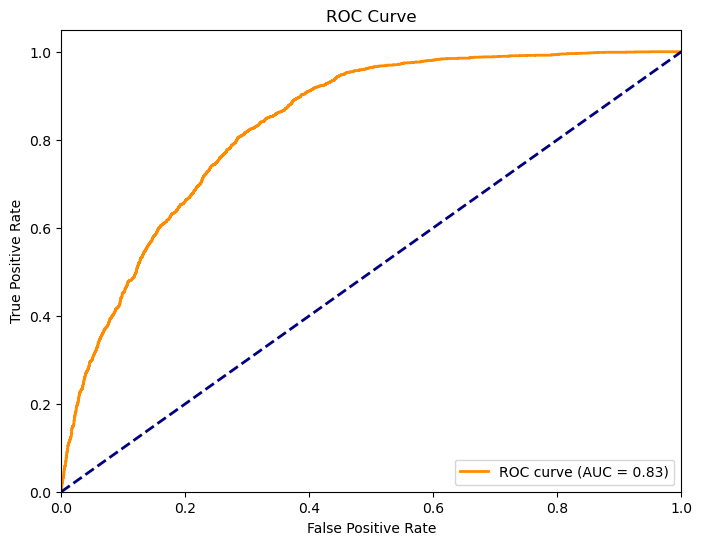

In [15]:
# Получаем вероятности положительного класса
probs = preds["p1"].as_data_frame().values
true_labels = test[target].as_data_frame().values.astype(int)

# Рассчитываем ROC
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
warnings.filterwarnings("default") # err-on


1. AUC = 0.835 Хороший результат
2. Accuracy = 0.553-0.754 Большой разброс значений (возможна нестабильность модели)
3. Precision:
- Класс 0: 0.911 -отлично
- Класс 1: 1.0 - идеально
4. Recall (Модель плохо обнаруживает класс 0):
- Класс 0: 0.018 - плохо
- Класс 1: 1.0 - идеально
5.  F1-score (Нуждается в улучшении для класса 0):
- Класс 0: 0.411 - низкий
- Класс 1: 0.701 - удовл.
6. LogLoss = 0.469 - низкий, требуется улучшение
- Проблеммы: 
    - Дисбаланс классов (очень низкий recall для класса 0)
    - Нестабильность accuracy (большой разброс значений)
    - Плохое распознавание класса 0 (precision хороший, но recall низкий)

In [16]:
# Матрица ошибок
print("\nМатрица ошибок:")
print(perf.confusion_matrix())


Матрица ошибок:
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3259820160260082
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      2576  1628  0.3873   (1628.0/4204.0)
1      234   2165  0.0975   (234.0/2399.0)
Total  2810  3793  0.282    (1862.0/6603.0)


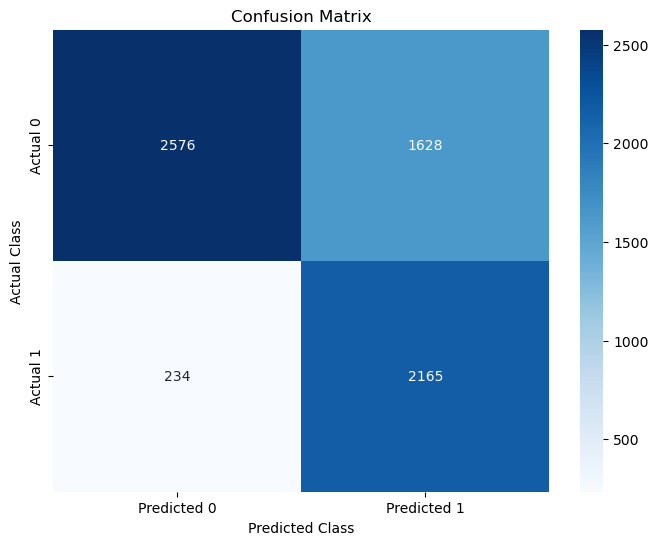

In [17]:
# Матрица ошибок
conf_matrix = perf.confusion_matrix()

cm_data = np.array(conf_matrix.to_list())
    
# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(cm_data, 
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

1. Класс 0:
- 1251 ложноположительных случаев (модель ошибочно предсказывает класс 1)
- Высокая ошибка 29.76% (каждый 3-й класс 0 определяется как класс 1)
2. Класс 1:
- 429 ложноотрицательных случаев
- Умеренная ошибка 17.88%
3. Общая точность:
- Общая ошибка классификации: 25.44%
- Правильные предсказания: 74.56%
### Выводы:
- Модель имеет перспективы. Требуется балансировка классов.
- Сравнение с другими моделями строенными на этих данных примерно похожи, проблемма таже - дисбаланс слассов

## Часть 2 «Прогнозирование временных рядов»

### Библиотеки

In [18]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import h2o
from h2o.automl import H2OAutoML

### Загрузка и подготовка данных

In [19]:
df_time = pd.read_csv('data/data_beer.csv')
df_time.head(5)

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


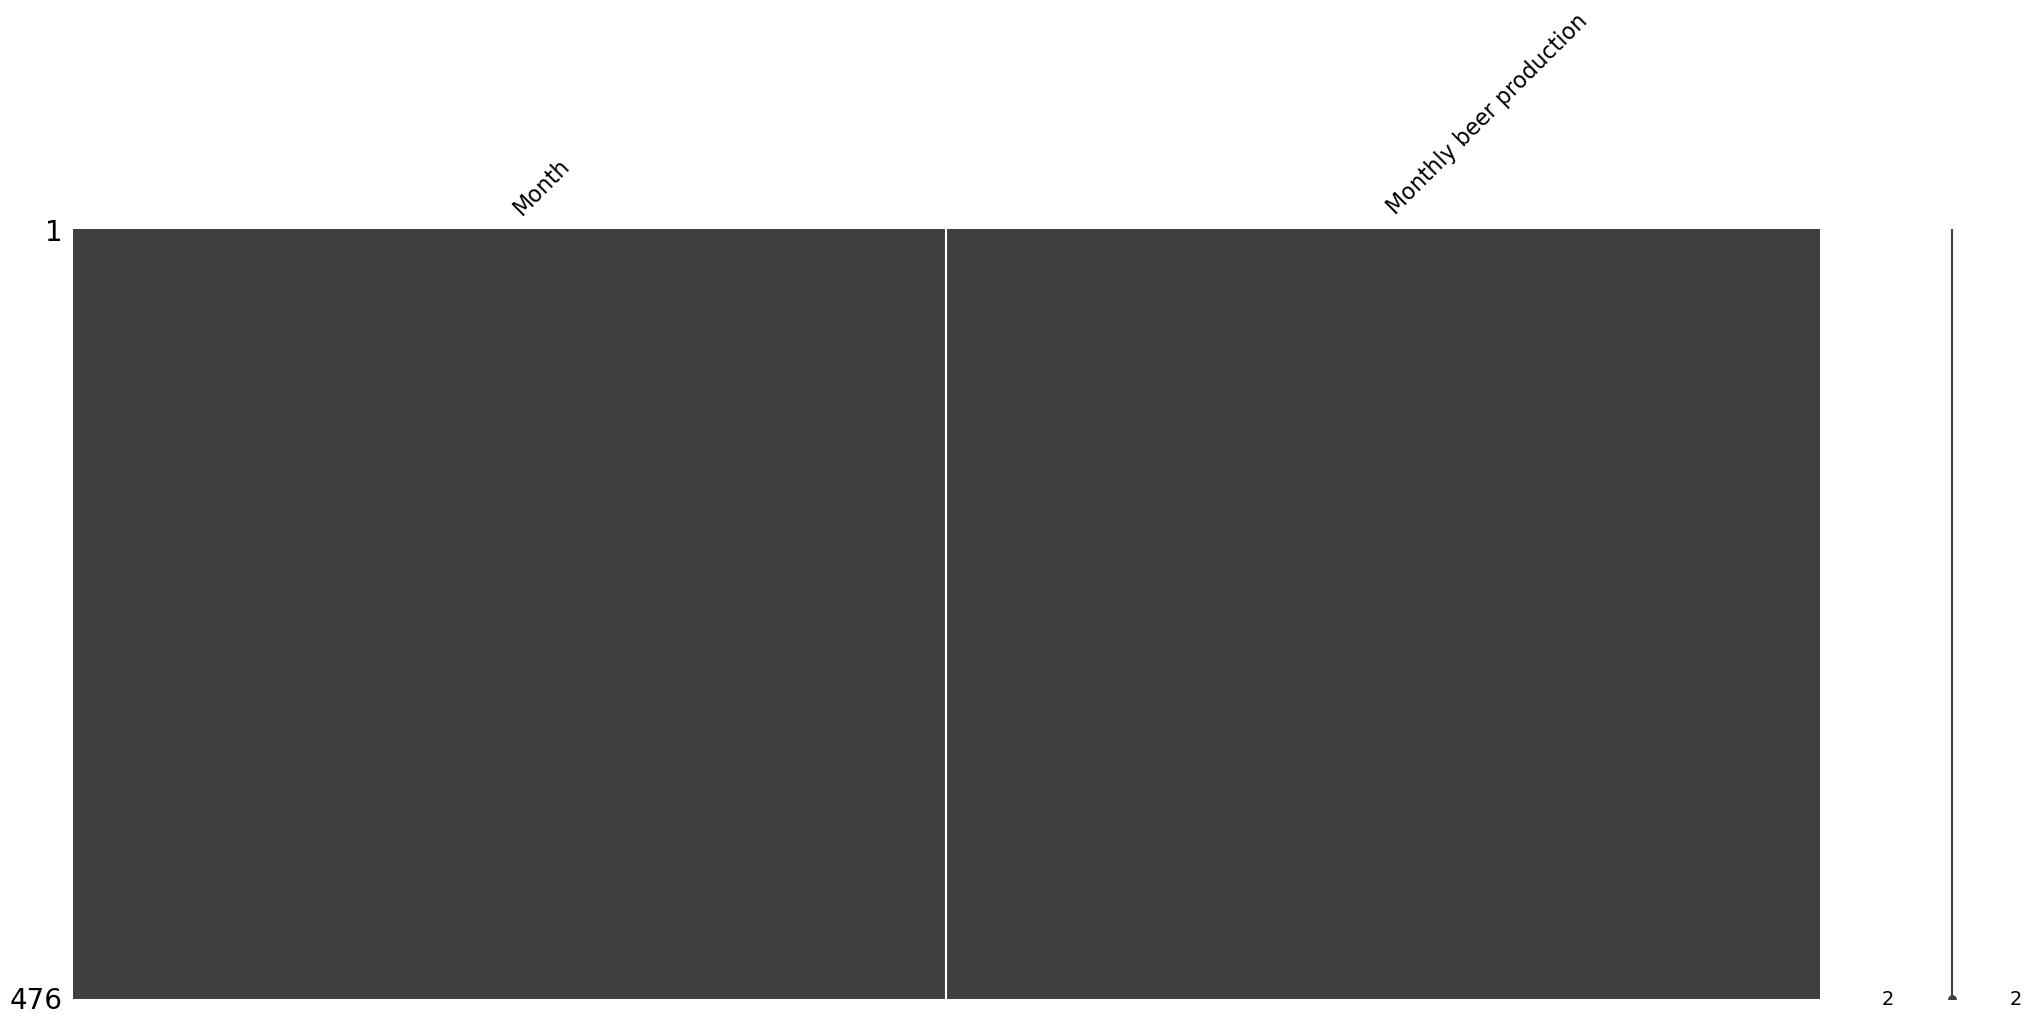

In [20]:
# Просмотр пропусков
msno.matrix(df_time)
plt.show()

In [21]:
df_time = df_time.rename(columns={'Month': 'date', 'Monthly beer production': 'production'})
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        476 non-null    object 
 1   production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [22]:
df_time['date'] = pd.date_range(start='1956-01', periods=len(df_time), freq='ME') # Добавление крайнего дня месяца
# df_time.set_index('data', inplace=True) # Установка даты индексом
df_time.head()

,date,production
0,1956-01-31,93.2
1,1956-02-29,96.0
2,1956-03-31,95.2
3,1956-04-30,77.1
4,1956-05-31,70.9


In [23]:
df_time.tail()

,date,production
471,1995-04-30,127.0
472,1995-05-31,151.0
473,1995-06-30,130.0
474,1995-07-31,119.0
475,1995-08-31,153.0


In [24]:
df_time.describe().T

,count,mean,min,25%,50%,75%,max,std
date,476,1975-11-15 00:30:15.126050432,1956-01-31 00:00:00,1965-12-23 06:00:00,1975-11-15 00:00:00,1985-10-07 18:00:00,1995-08-31 00:00:00,NaN
production,476.0,136.395378,64.8,112.9,139.15,158.825,217.8,33.738725


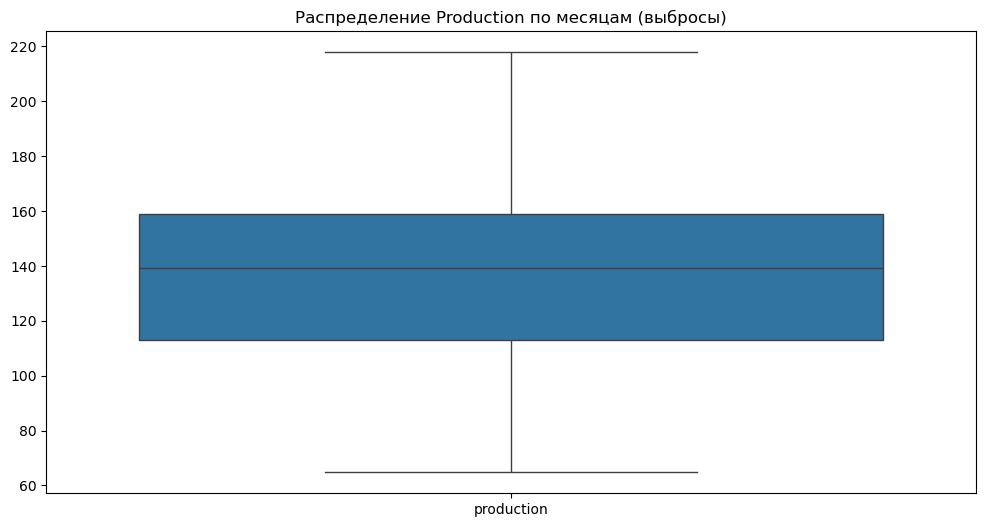

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_time)
plt.title('Распределение Production по месяцам (выбросы)')
plt.show()

- Данные загружены;
- Переименованы столбцы;
- Даты приведены в соответствие;
- Пропусков нет и пропущенных месяцев нет;
- Выбросы визуально не определяются.

### Подготовка H2O для временного ряда

In [26]:
# h2o.init()

In [ ]:
# Создание лаговых переменных
for lag in [3, 6, 12]:
    df_time[f'lag_{lag}'] = df_time['production'].shift(lag)
    

In [29]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        476 non-null    datetime64[ns]
 1   production  476 non-null    float64       
 2   lag_3       473 non-null    float64       
 3   lag_6       470 non-null    float64       
 4   lag_12      464 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 18.7 KB


In [30]:
# Конвертируем в H2OFrame
df_time = h2o.H2OFrame(df_time)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Разделение данных и обучение
x = ['date', 'lag_3', 'lag_6', 'lag_12'] 
y = 'production'

In [ ]:
# Разделяем на train/test
test_months = 24
train = df_time[:-test_months, :]
test = df_time[-test_months:, :]

In [33]:
# Параметры обучения
aml = H2OAutoML(
    max_models=15,
    max_runtime_secs=900,
    seed=42,
    sort_metric="RMSE",
    stopping_metric="RMSE",
    stopping_rounds=10,
    exclude_algos=["GLM", "DeepLearning"]
)

# Запуск AutoML
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
14:22:19.779: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_2_20250408_142219


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  2/3
# GBM base models (used / total)      1/1
# DRF base models (used / total)      1/2
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 31.347053158754075
RMSE: 5.598843912697877
MAE: 4.292887554438902
RMSLE: 0.04038322988509692
Mean Residual Deviance: 31.347053158754075
R^2: 0.9731785722068936
Null degrees of freedom: 451
Residual degrees of freedom: 449
Null deviance: 528266.7327426579
Residual deviance: 14168.868027756842
AIC: 2847.914793586827

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 139.16963759967848
RMSE: 11.797018165607717
MAE: 9.075116131999952
RMSLE: 0.08253747004419909
Mean Residual Deviance: 139.16963759967848
R^2: 0.8809225107391
Null degrees of freedom: 451
Residual degrees of freedom: 449
Null deviance: 533695.5421190483
Residual deviance: 62904.67619505468
AIC: 3521.653942761317

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     709.791    29.8567     680.043       729.824       708.61        681.931       748.545
loglikelihood           0          0           0             0             0             0             0
mae                     9.09283    0.867251    9.6451        7.6357        9.76402       9.43601       8.9833
mean_residual_deviance  140.021    29.098      141.645       92.5428       167.939       158.728       139.252
mse                     140.021    29.098      141.645       92.5428       167.939       158.728       139.252
null_deviance           106739     13298.1     94029.6       118866        120113        92034.4       108652
r2                      0.877464   0.0259984   0.870447      0.920364      0.873236      0.849489      0.873782
residual_deviance       12550      2154.45     12181.5       9069.19       14778.6       13491.9       13228.9
rmse                    11.776     1.29824     11.9015       9.61992       12.9591       12.5987       11.8005
rmsle                   0.0822776  0.00741256  0.0821754     0.0699905     0.0859895     0.0895636     0.0836689

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

### Сравнительная таблица с критериями качества по моделям

In [34]:
print("\nРезультаты AutoML:")
print(aml.leaderboard)


Результаты AutoML:
model_id                                                    rmse      mse      mae      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_2_20250408_142219  11.797   139.17   9.07512  0.0825375                   139.17
StackedEnsemble_AllModels_1_AutoML_2_20250408_142219     11.819   139.688  8.92642  0.0825116                   139.688
GBM_grid_1_AutoML_2_20250408_142219_model_5              12.0136  144.327  9.14073  0.0835469                   144.327
GBM_5_AutoML_2_20250408_142219                           12.1468  147.544  9.07691  0.0842424                   147.544
GBM_4_AutoML_2_20250408_142219                           12.1503  147.63   9.19065  0.0840916                   147.63
GBM_3_AutoML_2_20250408_142219                           12.1512  147.652  9.20432  0.084181                    147.652
GBM_grid_1_AutoML_2_20250408_142219_model_2              12.1961  148.746  9.16595  0.0849712                   148.746
GBM_grid_1_AutoML_2_20

### Визуализация

In [35]:
# Получение предсказаний на test, подготовка df для графика
import warnings
warnings.filterwarnings("ignore") # Куча ошибок не влияющих на работу - отключу пока
best_model = aml.leader
pred = best_model.predict(test)

train_df = train.as_data_frame()
test_df = test.as_data_frame()
pred_df = pred.as_data_frame()

results = pd.DataFrame({
    'date': test_df['date'],
    'actual': test_df['production'],
    'predicted': pred_df['predict']
})



stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


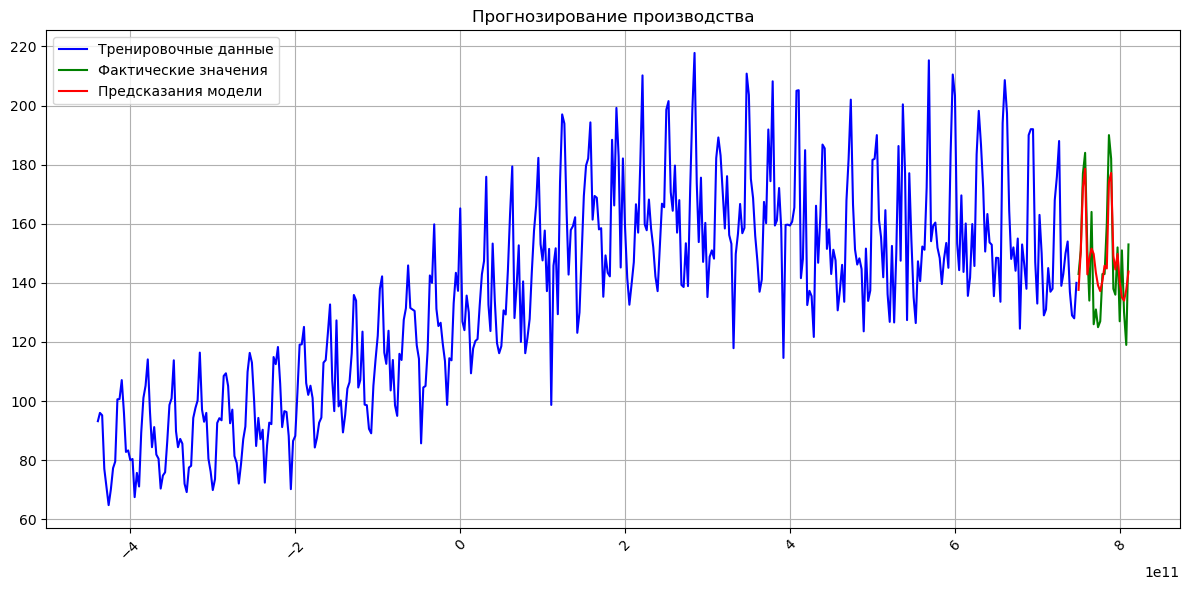

In [ ]:
# График
plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['production'], 
         label='Тренировочные данные', color='blue')
plt.plot(results['date'], results['actual'], 
         label='Фактические значения', color='green')
plt.plot(results['date'], results['predicted'], 
         label='Предсказания модели', color='red')

plt.title('Прогнозирование производства')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

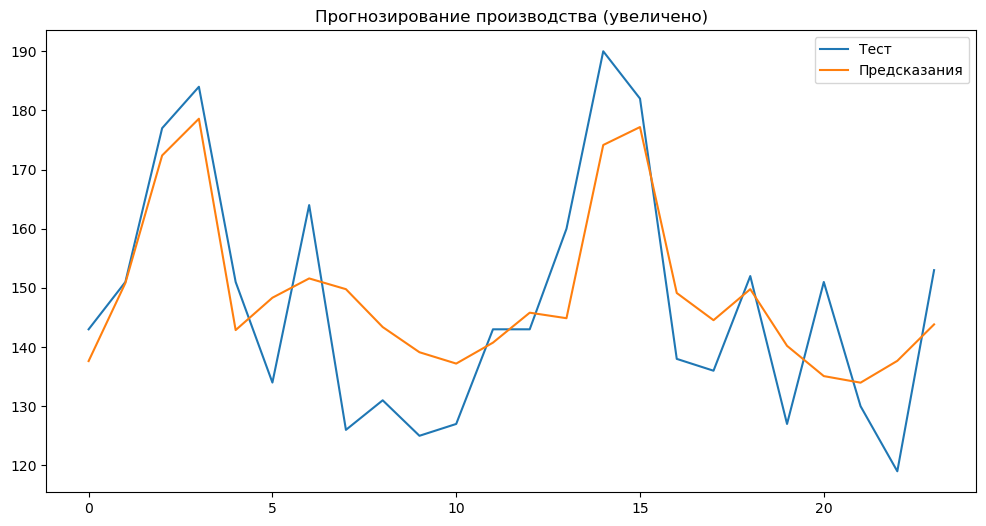

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(test_df['production'], label='Тест')
plt.plot(pred_df['predict'], label='Предсказания')
plt.title('Прогнозирование производства (увеличено)')
plt.legend()
plt.show()

Для сравнения прогнозирование ARIMA/SARIMA с прошлого домашнего задания

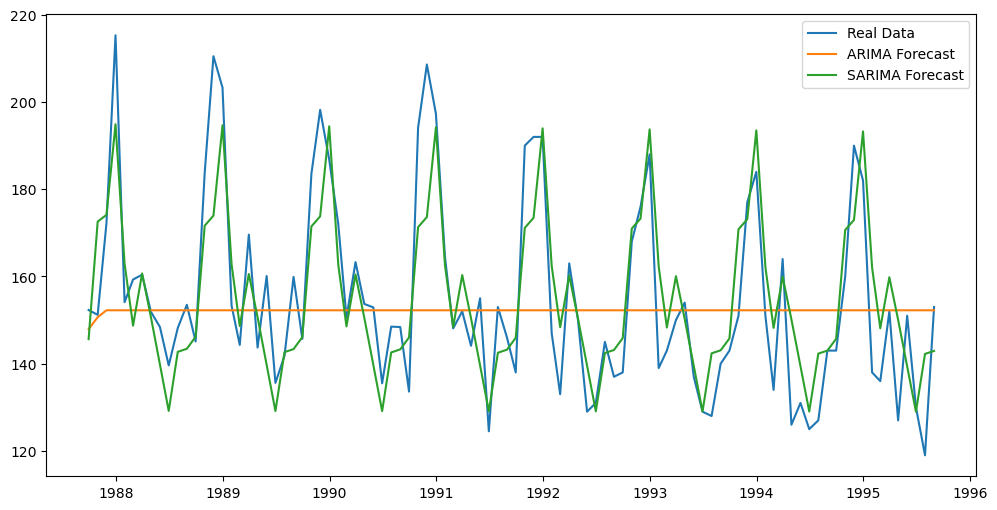

### Выводы

1. Метрики на тренировочных данных
- R² 0.973	Модель объясняет 97.3% дисперсии данных
- RMSE 5.60	Средняя ошибка ~5.6 единиц
- MAE 4.29 Среднее абсолютное отклонение
- RMSLE	0.040 Малая ошибка в логарифмической шкале
- Вывод: Модель демонстрирует почти идеальную точность на обучающей выборке.

2. Метрики кросс-валидации
- R² 0.877 Хорошая обобщающая способность
- RMSE 11.78 Возросшая ошибка предсказания
- MAE 9.09 Увеличение отклонения на новых данных
- RMSLE	0.082 Стабильность логарифмической ошибки
- Разница между train (RMSE=5.60) и CV (RMSE=11.78) указывает на умеренное переобучение.
3. Вывод:
-  метрики получились хорошие;
- умеренное переобучение;
- на графики видны значительные отклонения пердсказаний от тестовых данных. Возможно при таком подходе слабо учитываются сезонные признаки;
- SARIMA как то больше по душе для анализа временных рядов.